<a href="https://colab.research.google.com/github/Kate-Strydom/cse450/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import 

In [ ]:
#!pip install geopandas

In [ ]:
#from sys import platform

import pandas as pd
import numpy as np

import geopandas as gpd
import descartes
import shapely.geometry

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

from xgboost import XGBRegressor

#from sklearn import preprocessing, model_selection, ensemble, metrics, pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import GradientBoostingRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle


## Add Spatial to the Model

In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print("Loading Shapefile...")
#shapefile = gpd.read_file("/content/gdrive/My Drive/shapefile/tl_2016_53_cousub.shp")


Loading Shapefile...


In [ ]:
#fig, ax = plt.subplots(figsize = (15,15))
#shapefile.plot(ax=ax)

In [ ]:
# show shapefile
#shapefile.head()

In [ ]:
#shapefile.crs

In [ ]:
#shapefile.plot(column='NAME', figsize=(16,8))

## Data Preprocessing 

In [ ]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.9f' % x)
# reset
#pd.reset_option('display.float_format', silent=True)

In [ ]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
# data is from 2010 -2014
# inflation between 2014 and 2015 hardly changed.
zipcode = pd.read_csv('https://raw.githubusercontent.com/Kate-Strydom/cse450/main/notebooks/zipcode_washington.csv')

# merge data on zipcodes
data_merged = housing.merge(zipcode, left_on='zipcode', right_on='zipcode')
#print(housing.info())
#print(zipcode.info())
#print(housing.head())
#print(zipcode.head())
#print(data.head())
#print(data.describe())
#print(data.info())
# number of observations 
len(data_merged.index)

20000

In [ ]:
# rename lat : latitude and long: longitude
#data_merged.rename(columns={"lat": "latitude"}, inplace=True)

In [ ]:
#data_merged.info()

In [ ]:
#crs = {'init': 'epsg:4326' }


In [ ]:
# holdout sample to be submitted
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

In [ ]:
holdout.head()

id             date  bedrooms   bathrooms  sqft_living  sqft_lot  \
0  2591820310  20141006T000000         4 2.250000000         2070      8893   
1  7974200820  20140821T000000         5 3.000000000         2900      6730   
2  7701450110  20140815T000000         4 2.500000000         3770     10893   
3  9522300010  20150331T000000         3 3.500000000         4560     14608   
4  9510861140  20140714T000000         3 2.500000000         2550      5376   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0 2.000000000           0     0          4      8        2070              0   
1 1.000000000           0     0          5      8        1830           1070   
2 2.000000000           0     2          3     11        3770              0   
3 2.000000000           0     2          3     12        4560              0   
4 2.000000000           0     0          3      9        2550              0   

   yr_built  yr_renovated  zipcode          lat           long  sqft_living15  \
0      1986             0    98058 47.438800000 -122.162000000           2390   
1      1977             0    98115 47.678400000 -122.285000000           2370   
2      1997             0    98006 47.564600000 -122.129000000           3710   
3      1990             0    98034 47.699500000 -122.228000000           4050   
4      2004             0    98052 47.664700000 -122.083000000           2250   

   sqft_lot15  
0        7700  
1        6283  
2        9685  
3       14226  
4        4050

## Feature formatting

In [ ]:
# remove timestamp on training data 
data_merged['date'] = pd.to_datetime(data_merged['date'])
print ("min sale date, max sale date")
print(data_merged['date'].min(), data_merged['date'].max())

min sale date, max sale date
2014-05-02 00:00:00 2015-05-27 00:00:00


In [ ]:
# remove timestamp on hold out sample
holdout['date'] = pd.to_datetime(holdout['date'])
print ("min sale date, max sale date")
print(holdout['date'].min(), holdout['date'].max())

min sale date, max sale date
2014-05-02 00:00:00 2015-05-13 00:00:00


## Data Wrangling

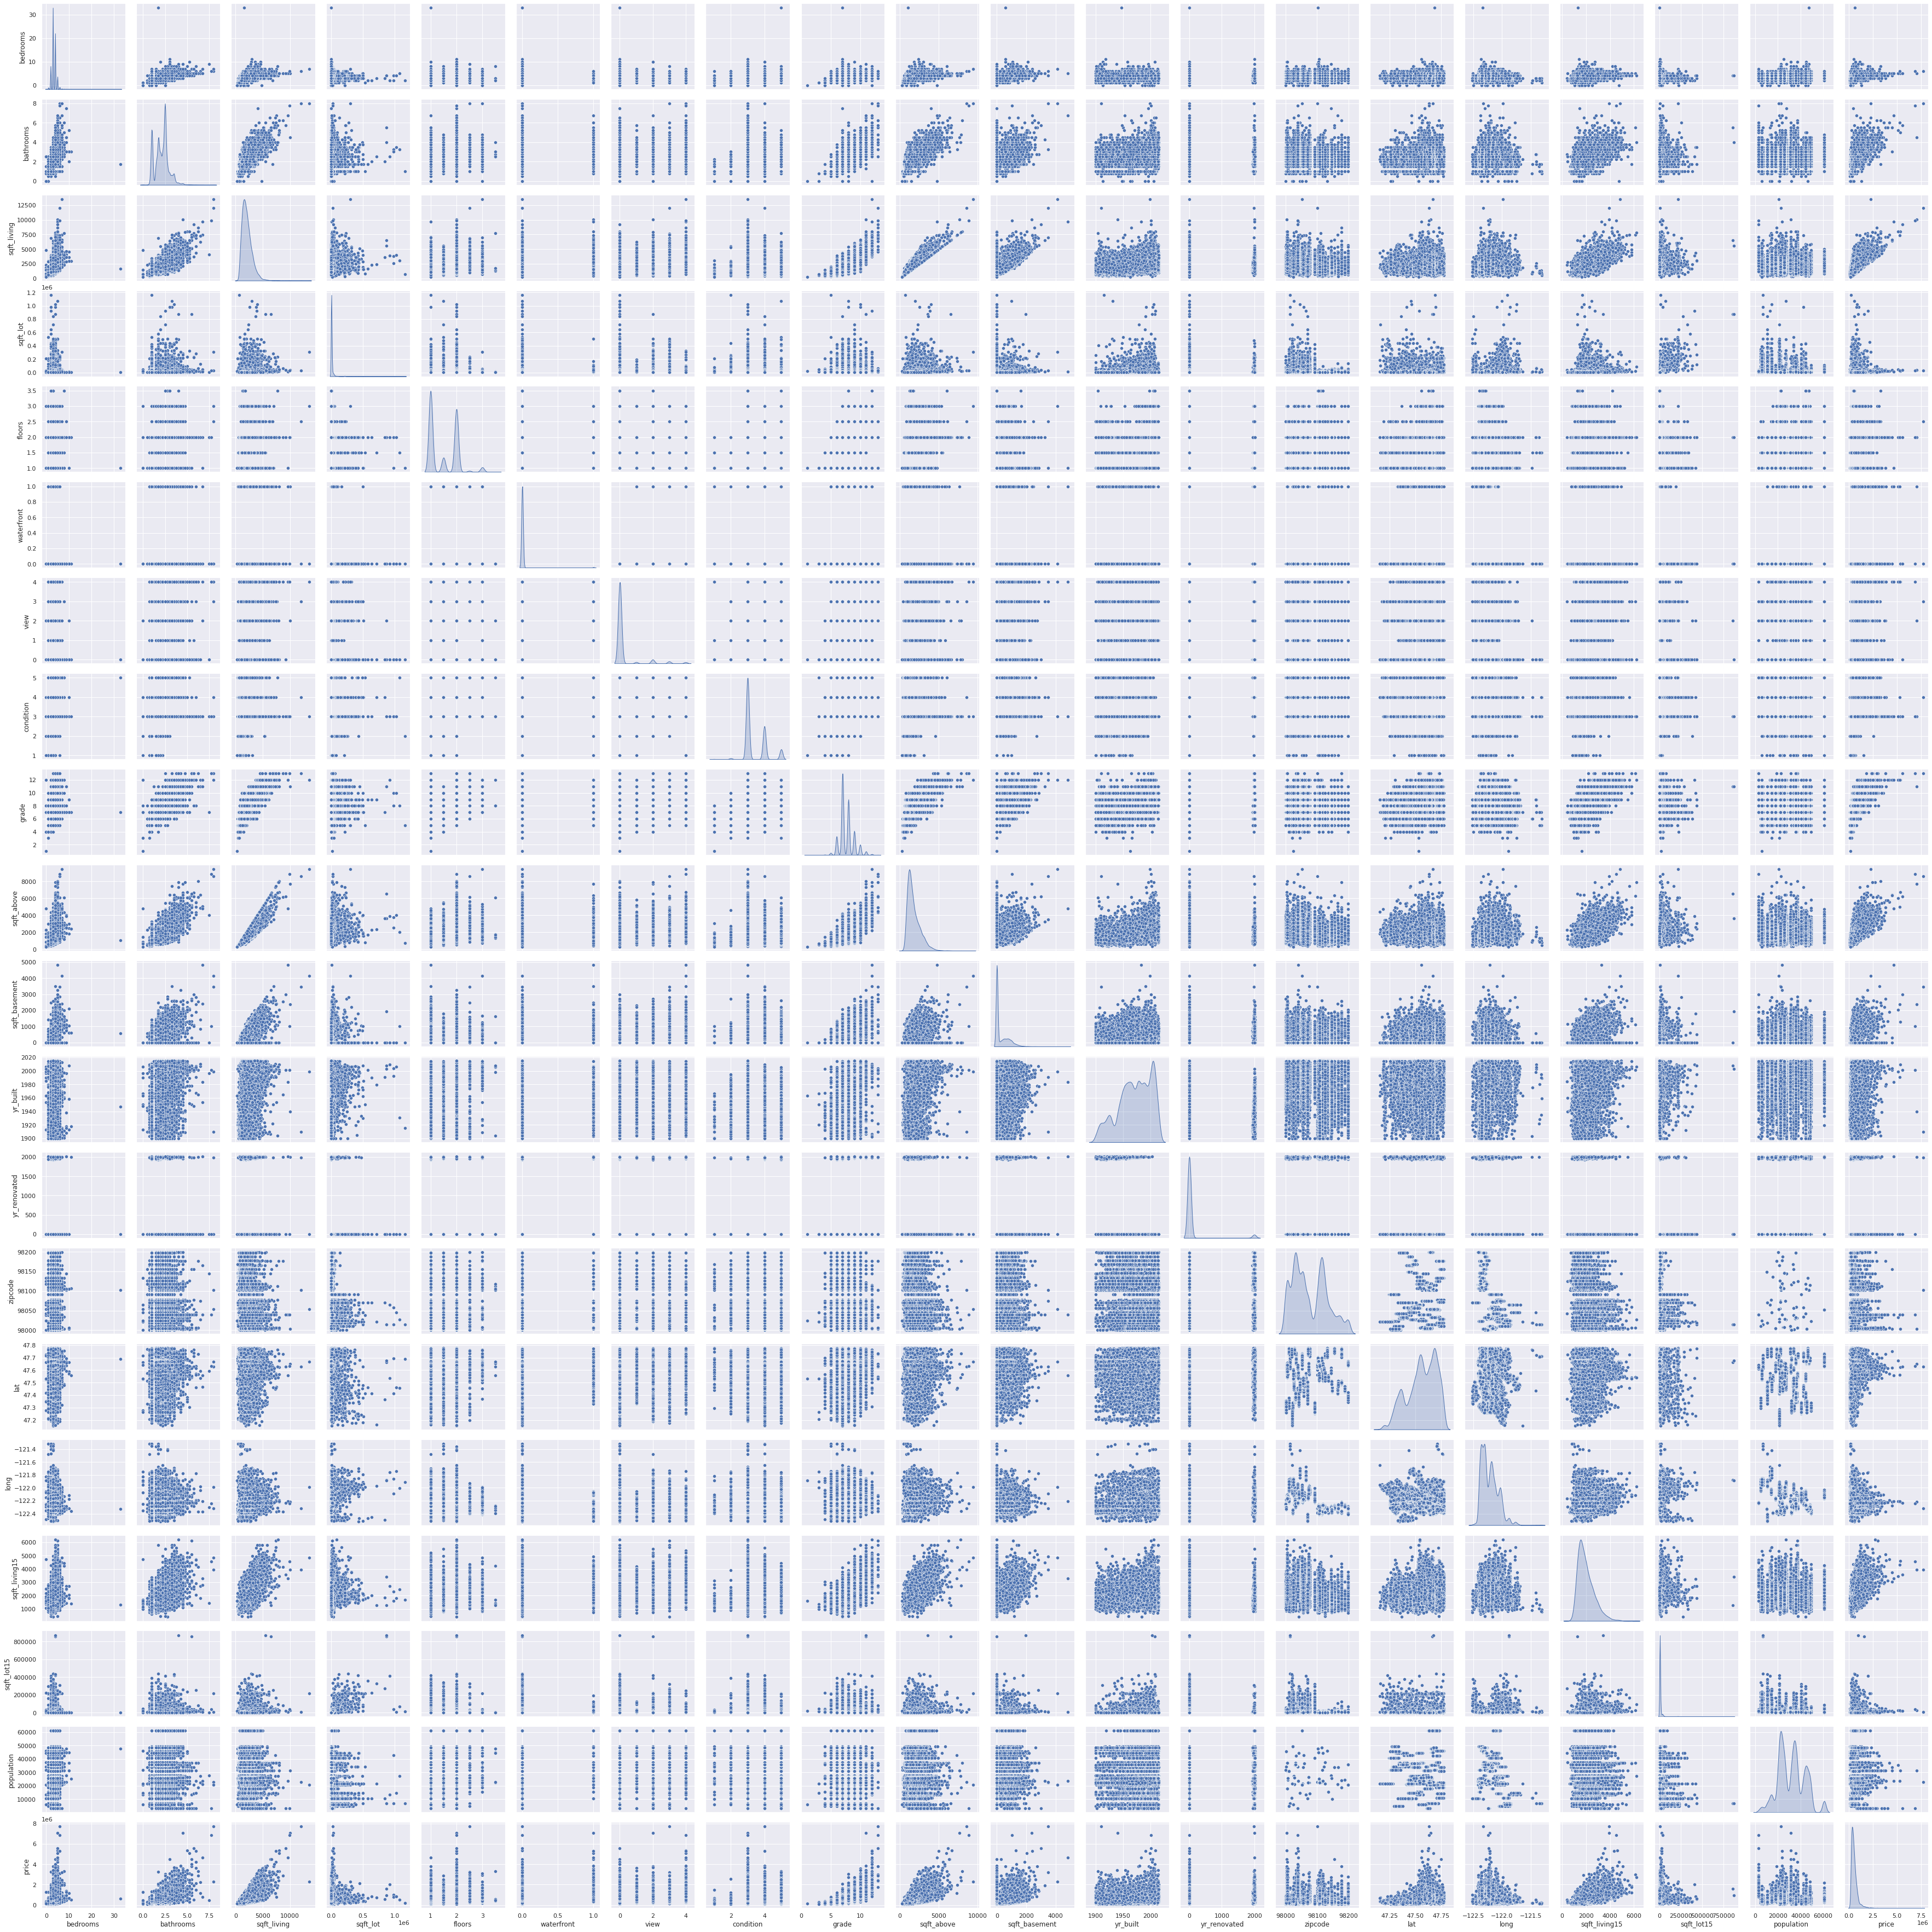

In [ ]:
# note we are plotting the data set because it is much smaller and will plot faster
features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'population', 'price']
sns.pairplot(data_merged[features], diag_kind="kde")

In [ ]:
# decision made by Porter, function from Porter
data_merged['price'].nlargest(n=10)

8930    7700000.000000000
4129    7062500.000000000
19871   6885000.000000000
19857   5570000.000000000
4061    5350000.000000000
18703   5300000.000000000
13374   5110800.000000000
18839   4668000.000000000
10177   4500000.000000000
4227    4489000.000000000
Name: price, dtype: float64

In [ ]:
# remove 33
data_merged['bedrooms'].nlargest(n=5)

3684     33
12592    11
4181     10
5368     10
17157    10
Name: bedrooms, dtype: int64

In [ ]:
data_merged['sqft_lot'].nsmallest(n=5)

11319    520
12610    572
11345    609
12602    635
11163    638
Name: sqft_lot, dtype: int64

In [ ]:
data_merged['sqft_living'].nsmallest(n=5)

19657    290
1462     370
8883     380
15744    384
3622     390
Name: sqft_living, dtype: int64

In [ ]:
data_merged['sqft_basement'].nlargest(n=5)

18839    4820
14365    4130
3052     3500
8930     3480
18811    3260
Name: sqft_basement, dtype: int64

In [ ]:
data_merged["floors"].value_counts()

1.000000000    9854
2.000000000    7655
1.500000000    1758
3.000000000     577
2.500000000     149
3.500000000       7
Name: floors, dtype: int64

In [ ]:
data_merged["condition"].value_counts()

3    12980
4     5247
5     1583
2      161
1       29
Name: condition, dtype: int64

In [ ]:
data_merged["grade"].value_counts()

7     8329
8     5597
9     2427
6     1880
10    1055
11     366
5      218
12      84
4       28
13      12
3        3
1        1
Name: grade, dtype: int64

## One-Hot Encoding

In [ ]:
#ONEHOT ENCODING BLOCK

#X_enc = pd.get_dummies(X_enc, columns=['sex','region','smoker'])

#mergedata = mergedata.drop(['sex','region','smoker'],axis=1)

## New Features

In [ ]:
# calculate age of the property
data_merged['yr_sold'] = pd. DatetimeIndex(data_merged['date']). year
data_merged['age_property'] = data_merged['yr_sold'] - data_merged['yr_built']
#data_merged['age_renovated'] = data_merged['yr_sold'] - data_merged['yr_renovated']
#data_merged['new_age_renovated'] = np.where(data_merged['yr_renovated'] == 0, 0 , data_merged['age_renovated'])
# indicator that property was renovated
data_merged['renovated'] = np.where(data_merged['yr_renovated'] == 0, 0, 1)
#data_merged['age_renovation'] = data_merged['yr_renovated'].apply(lambda x: 0  if x==0 else 1)


data_merged[['date','yr_sold', 'yr_built', 'yr_renovated', 'age_property', 'renovated']].head()

date  yr_sold  yr_built  yr_renovated  age_property  renovated
0 2014-11-04     2014      2007             0             7          0
1 2015-04-13     2015      2005             0            10          0
2 2014-09-08     2014      2005             0             9          0
3 2014-08-08     2014      1978             0            36          0
4 2015-05-12     2015      1985             0            30          0

In [ ]:
data_merged['renovated'].value_counts()

0    19171
1      829
Name: renovated, dtype: int64

In [ ]:
# create basement indicator
data_merged['basement'] = np.where(data_merged['sqft_basement'] == 0, 0, 1)


In [ ]:
print("basement")
data_merged['basement'].value_counts()


basement


0    12180
1     7820
Name: basement, dtype: int64

In [ ]:
# ratio variables
# bath:bed ratio
data_merged['bath_bed_ratio'] = data_merged['bedrooms']/data_merged['bathrooms']
data_merged[['bath_bed_ratio', 'bathrooms', 'bedrooms' ]]

bath_bed_ratio   bathrooms  bedrooms
0         1.230769231 3.250000000         4
1         1.600000000 2.500000000         4
2         1.200000000 2.500000000         3
3         2.000000000 2.500000000         5
4         1.200000000 2.500000000         3
...               ...         ...       ...
19995     1.500000000 2.000000000         3
19996     2.000000000 1.000000000         2
19997     1.200000000 2.500000000         3
19998     2.285714286 1.750000000         4
19999     1.200000000 2.500000000         3

[20000 rows x 3 columns]

William, The VP of Finance: "Our insurance customers are particularly interested in making sure that homes in unsavory neighborhoods, are not estimated high.
Question: Is there a way we can easily identify properties in lower income areas and have the model lower those estimates  to protect our insurance customers' interests?

In [ ]:
# create an adjusted median_household income feature. Assign arbitary values

def lowIncome(income):
    if income >=  80000:
        return income
    elif (income < 80000) & (income >= 65000):
       return income * 0.90
    else:
        return income * 0.70

data_merged['adjusted_median_household_income'] = data_merged['median_household_income'].apply(lowIncome)

In [ ]:
print("Adjusted minimum median household income: $%0.2f" % data_merged['adjusted_median_household_income'].min())
print("Minimum median household income: $%0.2f" % data_merged['median_household_income'].min())

Adjusted minimum median household income: $28459.20
Minimum median household income: $40656.00


Text(0.5, 0, 'Median Household Income')

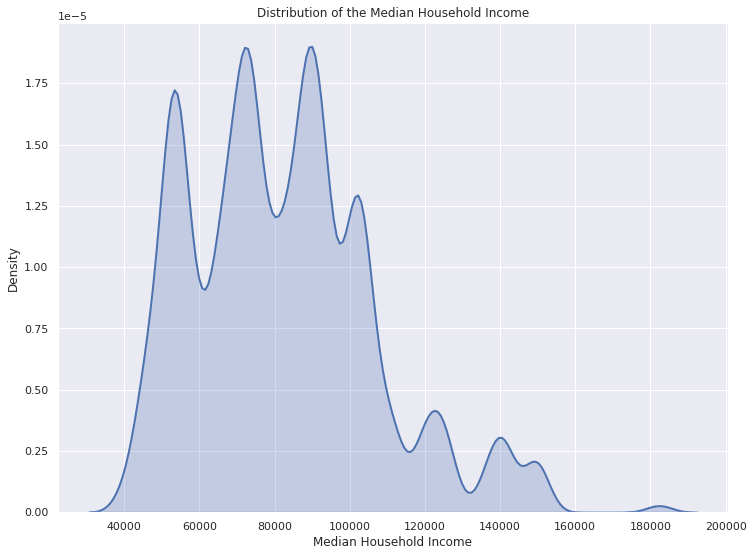

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=data_merged['median_household_income'], shade=True, linewidth=2)
ax.set_title("Distribution of the Median Household Income")
ax.set_xlabel("Median Household Income")

### Remove outliers

Outliers - bedrooms, sqft_lot, sqft_living and price as the mean is being pulled towards the extreme values

In [ ]:
# remove extreme values 
data = data_merged[(data_merged['bedrooms'] < 33) & (data_merged['price'] < 4400000)]
data.describe()

id        bedrooms       bathrooms     sqft_living  \
count      19989.000000000 19989.000000000 19989.000000000 19989.000000000   
mean  4579722686.091850281     3.367802291     2.113950173  2076.579718845   
std   2875050599.700168610     0.907298072     0.765381186   906.807932523   
min      1000102.000000000     0.000000000     0.000000000   290.000000000   
25%   2123049420.000000000     3.000000000     1.750000000  1430.000000000   
50%   3904950190.000000000     3.000000000     2.250000000  1910.000000000   
75%   7308900490.000000000     4.000000000     2.500000000  2550.000000000   
max   9900000190.000000000    11.000000000     8.000000000 13540.000000000   

               sqft_lot          floors      waterfront            view  \
count   19989.000000000 19989.000000000 19989.000000000 19989.000000000   
mean    15007.968432638     1.496247936     0.007304017     0.233578468   
std     39710.191498765     0.540935760     0.085152988     0.764769266   
min       520.000000000     1.000000000     0.000000000     0.000000000   
25%      5040.000000000     1.000000000     0.000000000     0.000000000   
50%      7620.000000000     1.500000000     0.000000000     0.000000000   
75%     10698.000000000     2.000000000     0.000000000     0.000000000   
max   1164794.000000000     3.500000000     1.000000000     4.000000000   

            condition           grade  ...       sqft_lot15             price  \
count 19989.000000000 19989.000000000  ...  19989.000000000   19989.000000000   
mean      3.409725349     7.655460503  ...  12744.588173495  536868.225474011   
std       0.651899113     1.171123709  ...  27082.260569024  347290.338204922   
min       1.000000000     1.000000000  ...    651.000000000   75000.000000000   
25%       3.000000000     7.000000000  ...   5100.000000000  321950.000000000   
50%       3.000000000     7.000000000  ...   7620.000000000  450000.000000000   
75%       4.000000000     8.000000000  ...  10083.000000000  641000.000000000   
max       5.000000000    13.000000000  ... 871200.000000000 4208000.000000000   

           population  median_household_income         yr_sold  \
count 19989.000000000          19989.000000000 19989.000000000   
mean  31905.567111912          82304.191705438  2014.321376757   
std   11502.091054688          24479.523054086     0.467016754   
min    3080.000000000          40656.000000000  2014.000000000   
25%   22772.000000000          65321.000000000  2014.000000000   
50%   31778.000000000          81037.000000000  2014.000000000   
75%   40610.000000000          93573.000000000  2015.000000000   
max   60920.000000000         182308.000000000  2015.000000000   

         age_property       renovated        basement  bath_bed_ratio  \
count 19989.000000000 19989.000000000 19989.000000000 19984.000000000   
mean     43.226424533     0.041322728     0.390714893             inf   
std      29.374222834     0.199040553     0.487922817             NaN   
min      -1.000000000     0.000000000     0.000000000     0.000000000   
25%      17.000000000     0.000000000     0.000000000     1.333333333   
50%      39.000000000     0.000000000     0.000000000     1.600000000   
75%      63.000000000     0.000000000     1.000000000     2.000000000   
max     115.000000000     1.000000000     1.000000000             inf   

       adjusted_median_household_income  
count                   19989.000000000  
mean                    76740.970643848  
std                     30006.023904961  
min                     28459.200000000  
25%                     58788.900000000  
50%                     81037.000000000  
75%                     93573.000000000  
max                    182308.000000000  

[8 rows x 28 columns]

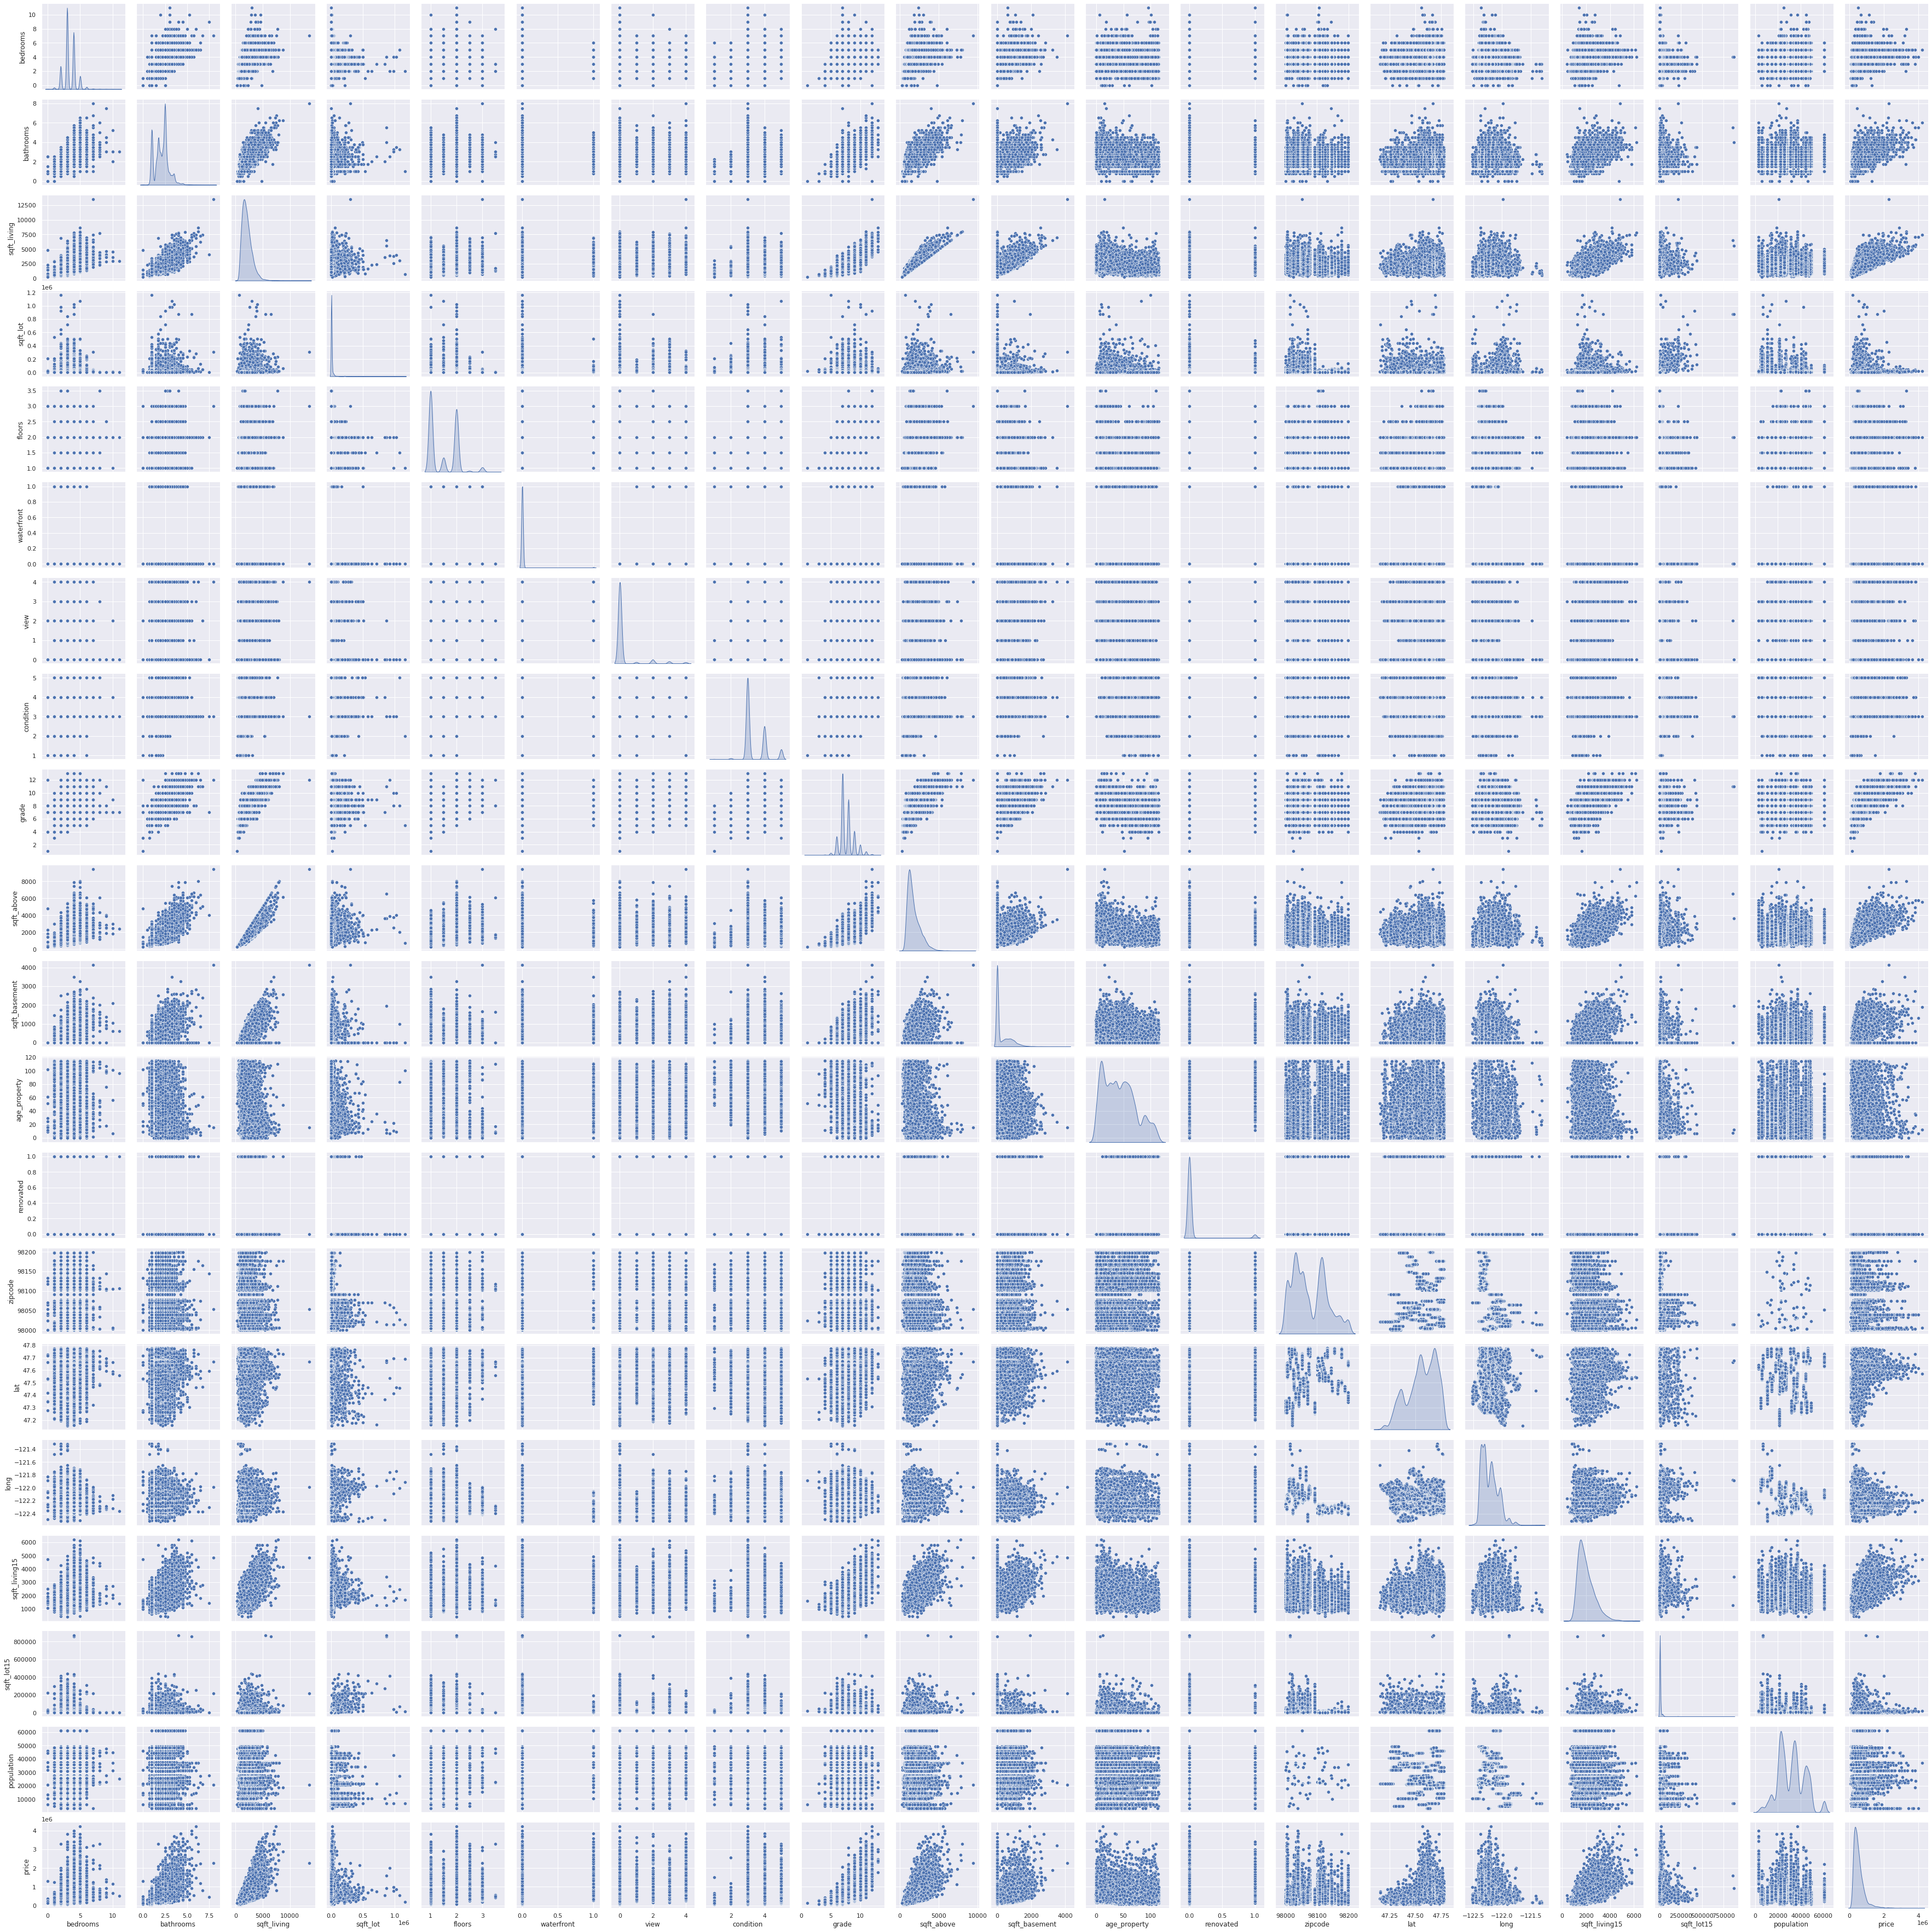

In [ ]:
# note we are plotting the data set because it is much smaller and will plot faster
features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_above', 'sqft_basement', 'age_property', 'renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'population', 'price']
sns.pairplot(data[features], diag_kind="kde")

### Correlation

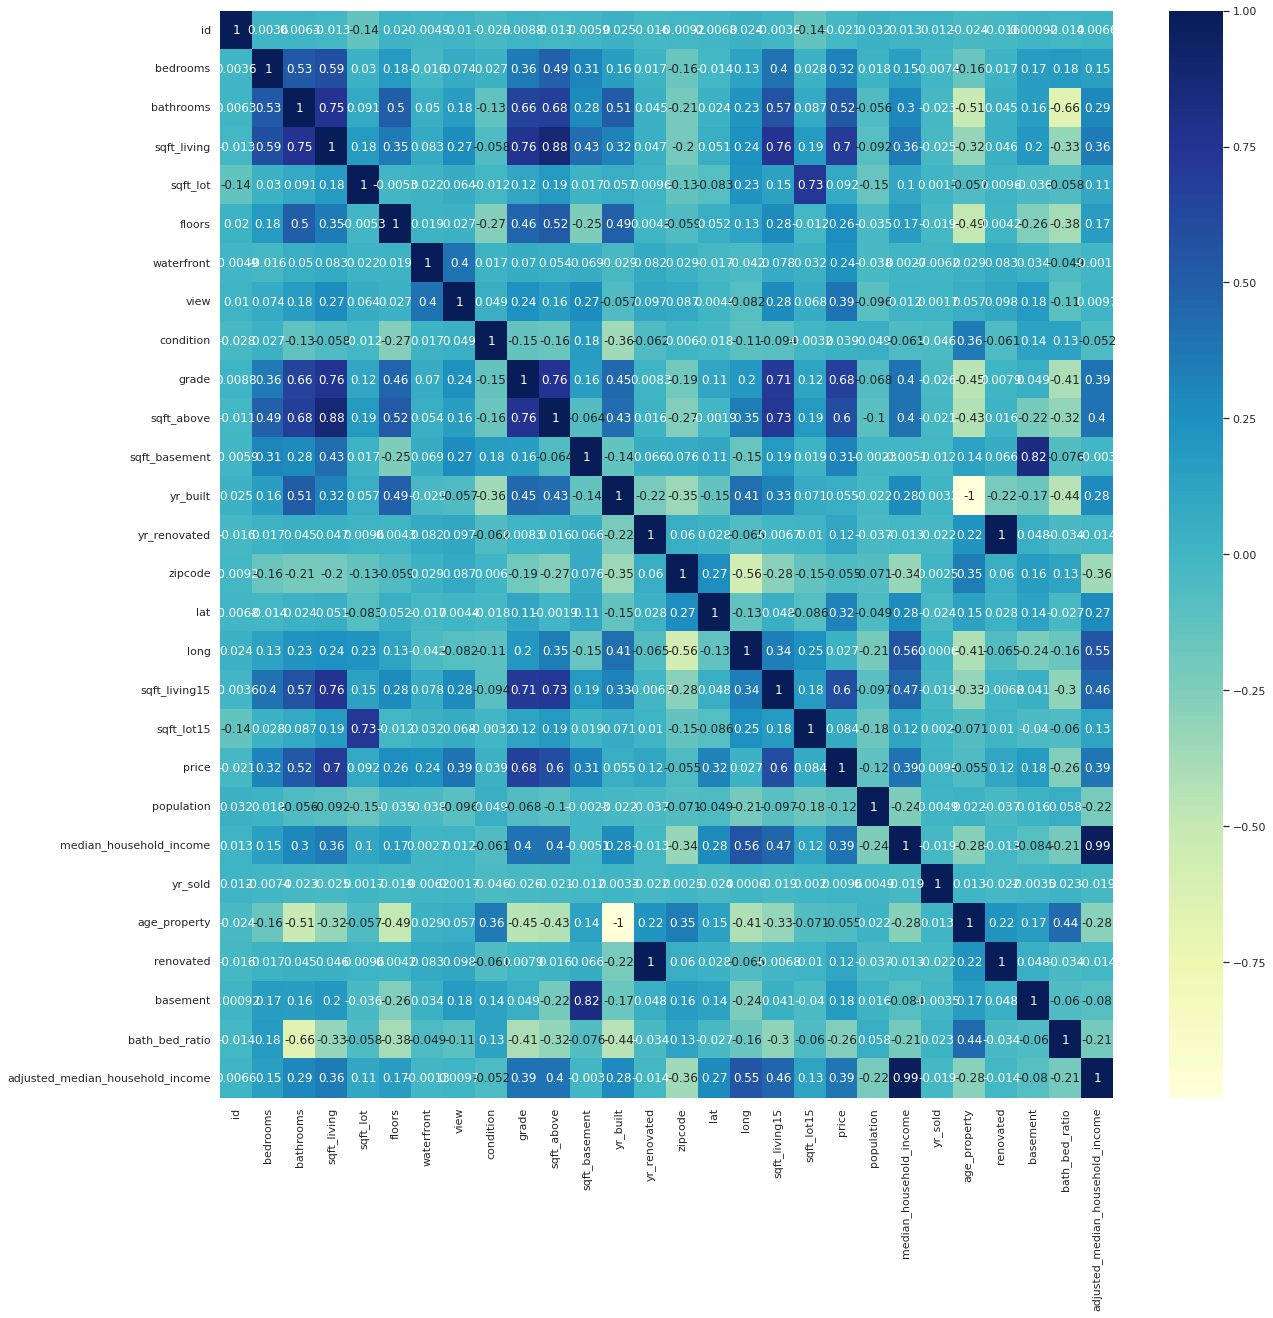

In [ ]:
# data df is the dataframe with outliers removed
data.corr()

sns.set(rc = {'figure.figsize':(20,20)})

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

Price has the highest positive correlation with grade followed by sqft_living. But grading and sqft_living are both highly correlated with each other. 

In [ ]:
# filter only sqft_living and price
df = data.loc[:, ['sqft_living', 'price']]
df.head()
min_sqft_living = df['sqft_living'].min()
print("Min sqft living: %d sq feet"  % (min_sqft_living))
max_sqft_living = df['sqft_living'].max()
print("Max sqft living: %d sq feet"  % (max_sqft_living))

Min sqft living: 290 sq feet
Max sqft living: 13540 sq feet


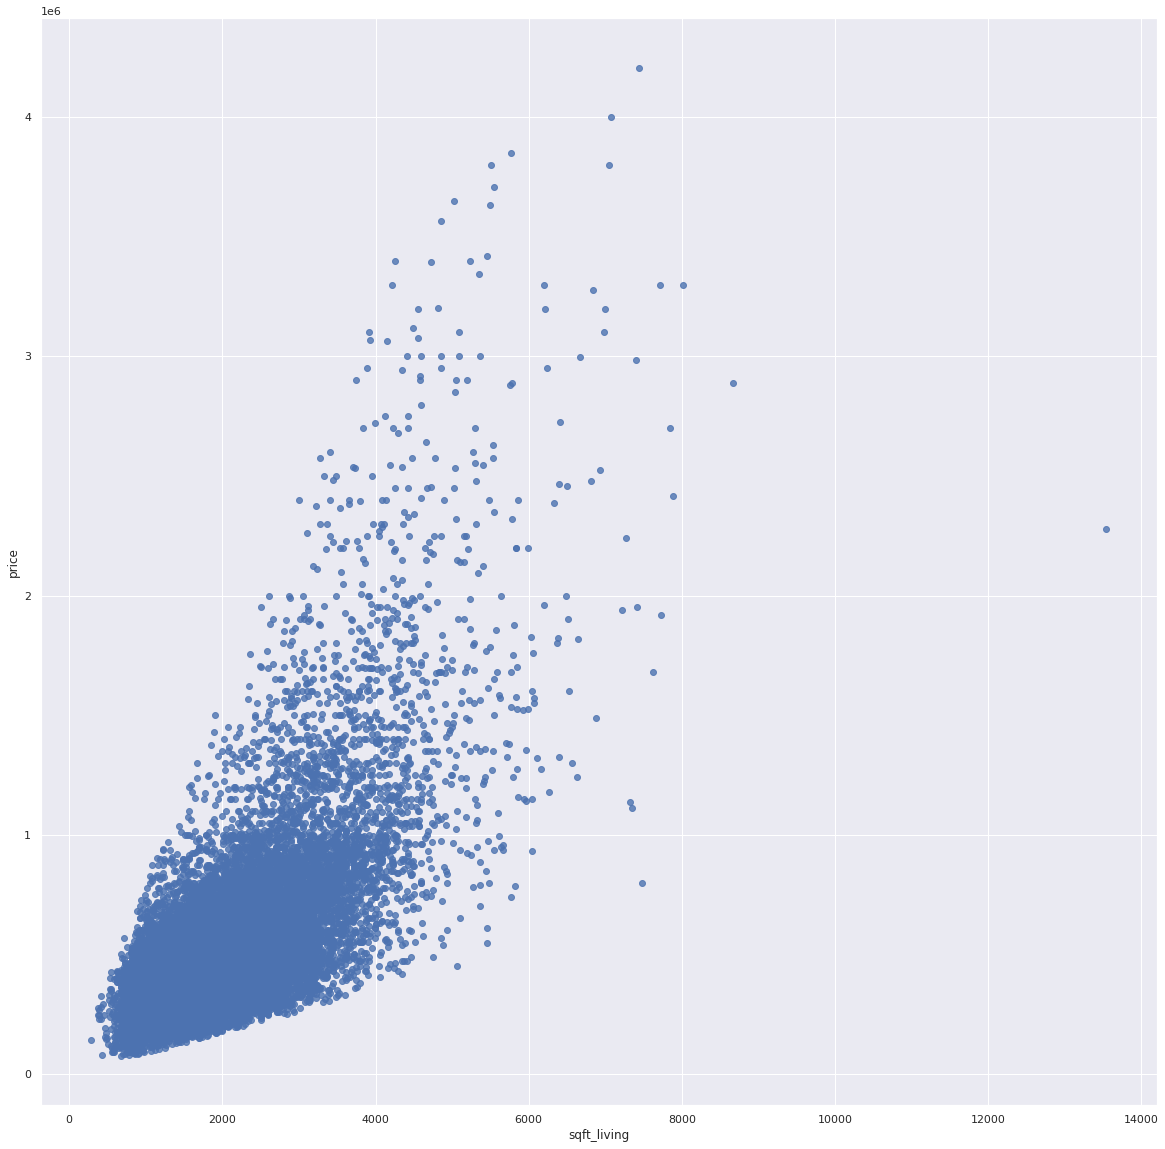

In [ ]:
# visualise sqft_living-price relationship
sns.regplot(x="sqft_living", y="price", data=df, fit_reg=False)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19989 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                19989 non-null  int64         
 1   date                              19989 non-null  datetime64[ns]
 2   bedrooms                          19989 non-null  int64         
 3   bathrooms                         19989 non-null  float64       
 4   sqft_living                       19989 non-null  int64         
 5   sqft_lot                          19989 non-null  int64         
 6   floors                            19989 non-null  float64       
 7   waterfront                        19989 non-null  int64         
 8   view                              19989 non-null  int64         
 9   condition                         19989 non-null  int64         
 10  grade                             19989 non-nu

## Normalization Section - Ignore

Don't run as the normalization does not improve the model

In [ ]:
# train-test 80-20 split
df_train, df_test = train_test_split(data, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 45)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_above', 'sqft_basement',  'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'adjusted_median_household_income', 'yr_sold', 'age_property', 'renovated', 'basement']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

id       date    bedrooms   bathrooms  sqft_living    sqft_lot  \
18553  3278604510 2014-06-25 0.272727273 0.312500000  0.113962264 0.001949713   
15018   349400100 2014-09-08 0.272727273 0.218750000  0.089811321 0.006278591   
13564  2726049169 2014-09-05 0.272727273 0.218750000  0.097358491 0.017236492   
6718   1714900060 2015-04-24 0.454545455 0.375000000  0.171320755 0.004230104   
11239  5316100780 2014-09-22 0.363636364 0.437500000  0.225660377 0.002817206   

           floors  waterfront        view   condition  ...  sqft_lot15  \
18553 0.400000000 0.000000000 0.000000000 0.500000000  ... 0.001590950   
15018 0.000000000 0.000000000 0.000000000 0.500000000  ... 0.007928330   
13564 0.000000000 0.000000000 0.000000000 0.500000000  ... 0.008212059   
6718  0.200000000 0.000000000 0.000000000 0.750000000  ... 0.005506870   
11239 0.400000000 0.000000000 0.000000000 0.500000000  ... 0.003617258   

                  price  population  median_household_income     yr_sold  \
18553  364000.000000000       21648                    67359 0.000000000   
15018  237500.000000000       21353                    65864 0.000000000   
13564  625000.000000000       37560                    52353 0.000000000   
6718   442000.000000000       24220                    52934 1.000000000   
11239 2575000.000000000       22290                   100694 0.000000000   

       age_property   renovated    basement  bath_bed_ratio  \
18553   0.034482759 0.000000000 0.000000000     1.200000000   
15018   0.301724138 0.000000000 0.000000000     1.714285714   
13564   0.387931034 0.000000000 0.000000000     1.714285714   
6718    0.767241379 0.000000000 1.000000000     1.666666667   
11239   0.034482759 0.000000000 1.000000000     1.142857143   

       adjusted_median_household_income  
18553                       0.209061754  
15018                       0.200316155  
13564                       0.053220435  
6718                        0.055863939  
11239                       0.469518124  

[5 rows x 29 columns]

In [ ]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
#df_test.head()

apply log transformation for y_train and y_test

In [ ]:
# apply log transformation to the train price
df_train['logprice'] = np.log(df_train['price'])
#print(df_train.head())

In [ ]:
# apply log transformation on test data price
df_test['logprice'] = np.log(df_test['price'])
#print(df_test.head())

Text(0.5, 0, 'Price of Houses')

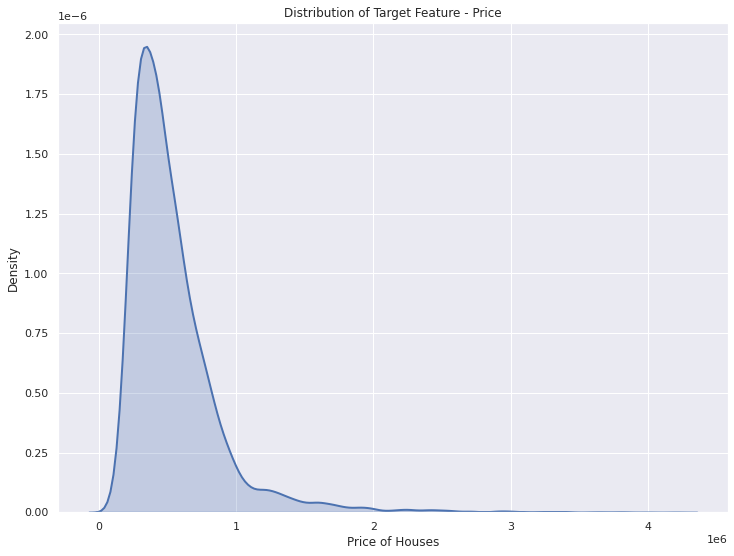

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['price'], shade=True, linewidth=2)
ax.set_title("Distribution of Target Feature - Price")
ax.set_xlabel("Price of Houses")

Text(0.5, 0, 'Log Price of Houses')

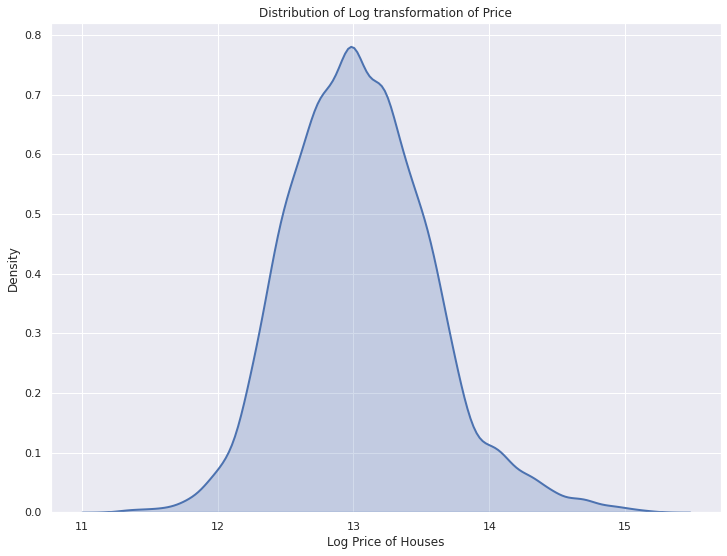

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['logprice'], shade=True, linewidth=2)
ax.set_title("Distribution of Log transformation of Price")
ax.set_xlabel("Log Price of Houses")

## Train Tree Models

Run this section, instead of the above.

In [ ]:
# train-test 80-20 split
df_train, df_test = train_test_split(data, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 45)


numeric_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_above', 'sqft_basement',  'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'adjusted_median_household_income', 'yr_sold', 'age_property', 'renovated', 'basement', 'price']
df_train = df_train[numeric_vars]
df_test = df_test[numeric_vars]
df_train.head()

bedrooms   bathrooms  sqft_living  sqft_lot      floors  waterfront  \
18553         3 2.500000000         1800      2790 2.000000000           0   
15018         3 1.750000000         1480      7830 1.000000000           0   
13564         3 1.750000000         1580     20588 1.000000000           0   
6718          5 3.000000000         2560      5445 1.500000000           0   
11239         4 3.500000000         3280      3800 2.000000000           0   

       view  condition  grade  sqft_above  ...          lat           long  \
18553     0          3      8        1800  ... 47.545500000 -122.371000000   
15018     0          3      7        1480  ... 47.196700000 -121.998000000   
13564     0          3      8        1580  ... 47.706000000 -122.290000000   
6718      0          4      7        1760  ... 47.550200000 -122.311000000   
11239     0          3     11        2880  ... 47.629900000 -122.280000000   

       sqft_living15  sqft_lot15  adjusted_median_household_income  yr_sold  \
18553           1580        2036                   60623.100000000     2014   
15018           1130        7553                   59277.600000000     2014   
13564           2080        7800                   36647.100000000     2014   
6718            1080        5445                   37053.800000000     2015   
11239           2050        3800                  100694.000000000     2014   

       age_property  renovated  basement             price  
18553             3          0         0  364000.000000000  
15018            34          0         0  237500.000000000  
13564            44          0         0  625000.000000000  
6718             88          0         1  442000.000000000  
11239             3          0         1 2575000.000000000  

[5 rows x 22 columns]

In [ ]:
# keep only model features
model_features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition','grade', 'sqft_above', 'sqft_basement',  'yr_renovated', 'lat', 'long',  'adjusted_median_household_income', 'yr_sold', 'age_property', 'renovated', 'basement']
#model_features = ['grade', 'sqft_living','lat', 'long','bathrooms', 'adjusted_median_household_income',  'view', 'condition','grade', 'sqft_above', 'sqft_basement',  'yr_renovated', 'lat', 'long',  'adjusted_median_household_income', 'yr_sold', 'age_property', 'renovated', 'basement']

#  divide into X_train, y_train, X_test, y_test
y_train = df_train['price']
#ytrain = df_train.pop('logprice')
X_train = df_train[model_features]

y_test = df_test['price']
#ytest = df_test.pop('logprice')
X_test = df_test[model_features]

In [ ]:
print("The length of the training set is: ", len(X_train), 
      "\nThe length of the testing data set is: ", len(X_test))

The length of the training set is:  15991 
The length of the testing data set is:  3998


In [ ]:
# first model with an arbitrary choice of n_features
# use log transformation

gbr = GradientBoostingRegressor(random_state=0, learning_rate = 0.1)
baseline = gbr.fit(X_train, y_train)
baseline.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
xgb = XGBRegressor(random_state=0)
model_xgb = xgb.fit(X_train, y_train)
xgb.get_params(deep=True)

[20:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# num of max features to be used in the model is a hyperparameter.
len(X_train.columns)

19

In [ ]:
# Get predictions for our test data
predictions_gbr = gbr.predict(X_test)
predictions_gbr

array([ 505422.41189944,  405910.3333272 ,  330163.92031826, ...,
       1468945.08323784,  353688.17806469,  358955.09545694])

In [ ]:
# Get predictions for our test data
predictions_xgb = xgb.predict(X_test)
predictions_xgb

array([ 509009.38,  413862.53,  327189.8 , ..., 1429824.5 ,  315869.9 ,
        364216.75], dtype=float32)

In [ ]:
# code enriched from Carlos - Gradient Boosting

from sklearn.metrics import mean_squared_error
import math
print("MSE:" ,(round(mean_squared_error(y_test, predictions_gbr),2)))
#print("RMSE:" ,(round(math.sqrt(mean_squared_error(y_test, predictions)),2)))
print("RMSE:" ,(round((mean_squared_error(y_test, predictions_gbr, squared=False )),2)))

from sklearn.metrics import mean_absolute_error
print("MAE:" ,round(mean_absolute_error(y_test, predictions_gbr),2))

from sklearn.metrics import r2_score
print("Rsq Score:" ,round(r2_score(y_test, predictions_gbr),2))

from sklearn.metrics import explained_variance_score
print("Variance Explained Score:" ,round(explained_variance_score(y_test, predictions_gbr),2))

from sklearn.metrics import median_absolute_error
print("Median absolute error :", round(median_absolute_error(y_test, predictions_gbr),2))

MSE: 12602743280.68
RMSE: 112261.94
MAE: 71625.74
Rsq Score: 0.88
Variance Explained Score: 0.88
Median absolute error : 45565.84


In [ ]:
# code enriched from Carlos - XGBoost

from sklearn.metrics import mean_squared_error
import math
print("MSE:" ,(round(mean_squared_error(y_test, predictions_xgb),2)))
#print("RMSE:" ,(round(math.sqrt(mean_squared_error(y_test, predictions)),2)))
print("RMSE:" ,(round((mean_squared_error(y_test, predictions_xgb, squared=False )),2)))

from sklearn.metrics import mean_absolute_error
print("MAE:" ,round(mean_absolute_error(y_test, predictions_xgb),2))

from sklearn.metrics import r2_score
print("Rsq Score:" ,round(r2_score(y_test, predictions_xgb),2))

from sklearn.metrics import explained_variance_score
print("Variance Explained Score:" ,round(explained_variance_score(y_test, predictions_xgb),2))

from sklearn.metrics import median_absolute_error
print("Median absolute error :", round(median_absolute_error(y_test, predictions_xgb),2))

MSE: 12816418543.53
RMSE: 113209.62
MAE: 72335.53
Rsq Score: 0.88
Variance Explained Score: 0.88
Median absolute error : 46106.98


In [ ]:
#paredo chart of features by feature importance by f_value from CSE250 - Gradient Boosting

df_features = pd.DataFrame({'f_names': X_train.columns,
                            'f_values': gbr.feature_importances_}).sort_values('f_values', ascending = False)
pareto_gbr = (alt.Chart(df_features.query('f_values > .02')).encode(
    alt.X('f_values'),
    alt.Y('f_names', sort = '-x'))
    .mark_bar()
.properties(width=700, height =600, title='Feature Importance for Gradient Boosting Regressor')
)

pareto_gbr

alt.Chart(...)

In [ ]:
#paredo chart of features by feature importance by f_value from CSE250 - xGBoost

df_features = pd.DataFrame({'f_names': X_train.columns,
                            'f_values': xgb.feature_importances_}).sort_values('f_values', ascending = False)
pareto_xgb = (alt.Chart(df_features.query('f_values > .02')).encode(
    alt.X('f_values'),
    alt.Y('f_names', sort = '-x'))
    .mark_bar()
.properties(width=700, height =600, title='Feature Importance for XGBoost Regressor')
)

pareto_xgb

alt.Chart(...)

## XGBoost Regressor

In [ ]:
X = X_train
y = y_train

In [ ]:
# create an xgboost regression model
xgb1 = XGBRegressor()
# create an xgboost regression model
#xgb2 = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb1, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores

array([-77875.80564453, -73451.10558594, -80966.46160156, -81521.97345703,
       -73709.84457031, -76943.67666016, -70940.83078125, -75128.65654297,
       -78422.19779297, -70922.010625  , -74305.75710938, -74597.89545526,
       -73307.33078457, -74432.67985372, -70609.06451424, -74925.58913486,
       -74332.82894634, -70539.66575407, -81583.58373748, -74759.921875  ,
       -72198.97189453, -69942.57228516, -77807.4978125 , -73429.51386719,
       -72083.83917969, -77403.19123047, -76296.62974609, -80980.21455078,
       -70943.64777344, -79154.5259375 , -71400.25154297, -74987.7458933 ,
       -72053.61637594, -72760.79093007, -77855.953653  , -75426.70994994,
       -81124.82319696, -75625.70662547, -82304.14713705, -72047.71325485,
       -72638.9990625 , -67859.88035156, -73619.35896484, -75591.69556641,
       -81067.57820312, -79751.17730469, -77571.56195312, -77940.06898438,
       -67920.90308594, -74200.51041016, -74828.16158203, -76636.92600125,
       -73431.19723874, -

## Save model

Gradient Boosting Regressor without normalization or feature selection has the best results so far.

MSE: 12602743280.68

RMSE: 112261.94

MAE: 71625.74

Rsq Score: 0.88

Variance Explained Score: 0.88

Median absolute error : 45565.84

In [ ]:
# save the model to disk
filename = 'finalized_price_model.sav'
pickle.dump(gbr, open(filename, 'wb'))

## Prepare Holdout Sample

### Add median_household_income

In [ ]:
# inflation between 2014 and 2015 hardly changed.
zipcode = pd.read_csv('https://raw.githubusercontent.com/Kate-Strydom/cse450/main/notebooks/zipcode_washington.csv')

# merge data on zipcodes
holdout_merged = holdout.merge(zipcode, left_on='zipcode', right_on='zipcode')

In [ ]:
# create an adjusted median_household income feature. Assign arbitary values

def lowIncome(income):
    if income >=  80000:
        return income
    elif (income < 80000) & (income >= 65000):
       return income * 0.90
    else:
        return income * 0.70

holdout_merged['adjusted_median_household_income'] = holdout_merged['median_household_income'].apply(lowIncome)

In [ ]:
# add other features created

## Score New Data